# Lab 3: Global Optimization with Gaussian Processes

## Gaussian Process Summer School 2023

The goal of this lab session is to illustrate the concepts seen during the tutorial in Gaussian processes for Global optimization. We will focus on two aspects of Bayesian Optimization (BO): (1) the choice of the model (2) the choice of the acquisition function.

The technical material associated to the methods used in this lab can be found in the slides of the tutorial. 

## 1. Getting started

Now, just as in the previous lab, specify to include plots in the notebook and to import relevant libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
 
import GPy
import numpy as np
from numpy.random import seed
seed(12345)

We will first define some utility functions for plotting. The next cell can be skimmed over as it contains no information relevent to learning about BO.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from emukit.core import ParameterSpace
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop


def plot_acquisition(emukit_bo_loop: BayesianOptimizationLoop, space: ParameterSpace,
                     label_x: str=None, label_y: str=None):
    """
    Plots the model and the acquisition function.
        if self.input_dim = 1: Plots data, mean and variance in one plot and the acquisition function in another plot
        if self.input_dim = 2: as before but it separates the mean and variance of the model in two different plots
    :param label_x: Graph's x-axis label, if None it is renamed to 'x' (1D) or 'X1' (2D)
    :param label_y: Graph's y-axis label, if None it is renamed to 'f(x)' (1D) or 'X2' (2D)
    """
    return _plot_acquisition(space.get_bounds(),
                            emukit_bo_loop.loop_state.X.shape[1],
                            emukit_bo_loop.model,
                            emukit_bo_loop.model.X,
                            emukit_bo_loop.model.Y,
                            emukit_bo_loop.candidate_point_calculator.acquisition,
                            emukit_bo_loop.get_next_points(None),
                            label_x,
                            label_y)

def _plot_acquisition(bounds, input_dim, model, Xdata, Ydata, acquisition_function, suggested_sample,
                     label_x=None, label_y=None, color_by_step=True):
    '''
    Plots of the model and the acquisition function in 1D and 2D examples.
    '''

    if input_dim ==1:
        # Plots for 1D input
        if not label_x:
            label_x = 'x'

        if not label_y:
            label_y = 'f(x)'

        x_grid = np.arange(bounds[0][0], bounds[0][1], 0.001)
        x_grid = x_grid.reshape(len(x_grid),1)
        acq = acquisition_function.evaluate(x_grid)
        acq_normalized = (acq - min(acq))/(max(acq) - min(acq))
        m, v = model.predict(x_grid)

        upper_conf_bound = m[:, 0] + 1.96 * np.sqrt(v)[:, 0]
        lower_conf_bound = m[:, 0] - 1.96 * np.sqrt(v)[:, 0]

        plt.fill_between(x_grid[:, 0], upper_conf_bound, lower_conf_bound, color='b', alpha=0.2)
        plt.plot(x_grid, lower_conf_bound, 'k-', alpha=0.2)
        plt.plot(x_grid, upper_conf_bound, 'k-', alpha=0.2)
        plt.plot(x_grid, m, 'k-', lw=1, alpha=0.6)

        plt.plot(Xdata, Ydata, 'r.', markersize=10)
        plt.axvline(x=suggested_sample[len(suggested_sample)-1], color='r')
        factor = max(upper_conf_bound) - min(lower_conf_bound)

        plt.plot(x_grid, 0.2*factor*acq_normalized - abs(min(lower_conf_bound)) - 0.25*factor, 'r-',
                 lw=2, label='Acquisition')
        plt.xlabel(label_x)
        plt.ylabel(label_y)
        plt.ylim(min(lower_conf_bound) - 0.25*factor,  max(upper_conf_bound) + 0.05*factor)
        plt.axvline(x=suggested_sample[len(suggested_sample)-1],color='r')
        plt.legend(loc='upper left')

    elif input_dim == 2:

        if not label_x:
            label_x = 'X1'

        if not label_y:
            label_y = 'X2'

        n = Xdata.shape[0]
        colors = np.linspace(0, 1, n)
        cmap = plt.cm.Reds
        norm = plt.Normalize(vmin=0, vmax=1)
        points_var_color = lambda X: plt.scatter(
            X[:,0], X[:,1], c=colors, label=u'Observations', cmap=cmap, norm=norm)
        points_one_color = lambda X: plt.plot(
            X[:,0], X[:,1], 'r.', markersize=10, label=u'Observations')
        X1 = np.linspace(bounds[0][0], bounds[0][1], 200)
        X2 = np.linspace(bounds[1][0], bounds[1][1], 200)
        x1, x2 = np.meshgrid(X1, X2)
        X = np.hstack((x1.reshape(200*200,1),x2.reshape(200*200,1)))
        acq = acquisition_function.evaluate(X)
        acq_normalized = (acq - min(acq))/(max(acq) - min(acq))
        acq_normalized = acq_normalized.reshape((200,200))
        m, v = model.predict(X)
        plt.figure(figsize=(15,5))
        plt.subplot(1, 3, 1)
        plt.contourf(X1, X2, m.reshape(200,200),100)
        plt.colorbar()
        if color_by_step:
            points_var_color(Xdata)
        else:
            points_one_color(Xdata)
        plt.ylabel(label_y)
        plt.title('Posterior mean')
        plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
        ##
        plt.subplot(1, 3, 2)
        plt.contourf(X1, X2, np.sqrt(v.reshape(200,200)),100)
        plt.colorbar()
        if color_by_step:
            points_var_color(Xdata)
        else:
            points_one_color(Xdata)
        plt.xlabel(label_x)
        plt.ylabel(label_y)
        plt.title('Posterior sd.')
        plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
        ##
        plt.subplot(1, 3, 3)
        plt.contourf(X1, X2, acq_normalized,100)
        plt.colorbar()
        plt.plot(suggested_sample[:,0],suggested_sample[:,1],'m.', markersize=10)
        plt.xlabel(label_x)
        plt.ylabel(label_y)
        plt.title('Acquisition function')
        plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))

    else:
        raise ValueError(f'Cannot plot inputs higher than 2D, {input_dim} given')

def plot_convergence(X, Y):
    '''
    Plots the convergence of standard Bayesian optimization algorithms.

    :param X: Locations of evaluated points
    :param Y: Results of evaluations

    '''
    n = X.shape[0]

    ## Distances between consecutive x's
    aux = (X[1:n,:] - X[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')

    # Best found value at each iteration
    best_Y = np.minimum.accumulate(Y)

    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y, '-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')



### Remembering the basics

Before starting with the lab, remember that (BO) is an heuristic for global optimization of black-box functions. Let $f: {\mathcal X} \to R$ be a 'well behaved' continuous function defined on a compact subset ${\mathcal X} \subseteq R^d$. Our goal is to solve the global optimization problem of finding
$$ x_{M} = \arg \min_{x \in {\mathcal X}} f(x). $$

We assume that $f$ is a *black-box* from which only perturbed evaluations of the type $y_i = f(x_i) + \epsilon_i$, with $\epsilon_i \sim\mathcal{N}(0,\sigma^2)$, are  available. The goal is to find $x_M$ by minimizing the number of evaluations of $f$. To do this, we need to determine two crucial bits:

1. A **Gaussian process** that will capture the our beliefs on $f$. 

2. An **acquisition function** that based on the model will be useful to determine where to collect new evaluations of f. 

Remember that every time a new data point is collected the model is updated and the acquisition function optimized again. 

### Running example

We start with a one-dimensional example. Consider here the Forrester function 

$$ f(x) =(6x-2)^2 \sin(12x-4) $$

defined on the interval $[0, 1]$.

The minimum of this function is located at $x_{min}=0.78$. We assume that the evaluations of $f$ to are perturbed by zero-mean Gaussian noise with standard deviation 0.25. The Forrester function is part of the benchmark of functions of Emukit. To create the true function, the perturbed version and the boundaries of the problem you need to run the following cell. 

In [3]:
from emukit.test_functions import forrester_function

f_true, bounds = forrester_function()             # true function and parameter space
f_objective, _ = forrester_function(noise_standard_deviation=.25)        # noisy version, will be used as noisy objective


Let's plot the true $f$:

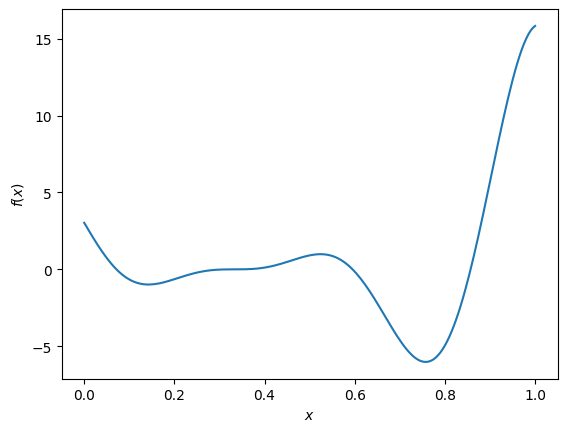

In [4]:
x_plot = np.linspace(bounds.parameters[0].min, bounds.parameters[0].max, 200)[:, None]
y_plot = f_true(x_plot)

plt.plot(x_plot, y_plot)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

`f_objective` is the function that we are going to optimize. You can define your own objective but it should be able to map any numpy array of dimension $n\times d$ (inputs) to a numpy array of dimension $n\times 1$ (outputs). For instance:

In [5]:
n = 8
x = np.random.rand(n).reshape(n,1)
x

array([[0.92961609],
       [0.31637555],
       [0.18391881],
       [0.20456028],
       [0.56772503],
       [0.5955447 ],
       [0.96451452],
       [0.6531771 ]])

In [6]:
f_objective(x)

array([[ 9.99379804],
       [ 0.30951655],
       [-0.53213703],
       [-0.92083089],
       [ 0.70757395],
       [ 0.04499155],
       [14.12247715],
       [-2.14113699]])

In Emukit the bounds of the problem are defined as a `ParameterSpace` object. For real valued parameters the upper and lower limits of the box in which the optimization will be performed shall be provided. In our example:

In [7]:
from emukit.core import ParameterSpace, ContinuousParameter

custom_bounds = ParameterSpace([
    ContinuousParameter('var_1', 0.0, 1.0)
])

To use BO to solve this problem, we need to create an Emukit object in which we need to specify the following elements: 
* The function to optimize.
* The box constrains of the problem.
* The model, that is fixed by default to be a GP with a SE kernel.
* The acquisition function (and its parameters).

We create an SE kernel as we do in GPy

In [8]:
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

X_init = np.random.rand(3).reshape(3,1)
Y_init = f_objective(X_init)

k = GPy.kern.RBF(1)
gpy_model = GPy.models.GPRegression(X_init, Y_init, k)
emukit_model = GPyModelWrapper(gpy_model)

And now we have all the elements to start optimizing $f$. We create the optimization problem instance. Note that you don't need to specify the evaluation budget of. This is because at this stage we are not running the optimization, we are just initializing the different elements of the BO algorithm. 

In [9]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

# Creation of the object that we will use to run BO.
myBopt = BayesianOptimizationLoop(space=bounds, model=emukit_model)

In [10]:
?BayesianOptimizationLoop

Init signature:
BayesianOptimizationLoop(
    space: emukit.core.parameter_space.ParameterSpace,
    model: emukit.core.interfaces.models.IModel,
    acquisition: emukit.core.acquisition.acquisition.Acquisition = None,
    update_interval: int = 1,
    batch_size: int = 1,
    acquisition_optimizer: emukit.core.optimization.acquisition_optimizer.AcquisitionOptimizerBase = None,
)
Docstring:     
Generic outer loop that provides the framework for decision making parts of Emukit.

The loop can be used in two modes:

1. Emukit calculates the next point(s) to try and evaluates your function at these points until some stopping
   criterion is met.
2. Emukit only calculates the next points(s) to try and you evaluate your function or perform the experiment.

This object exposes the following events. See ``emukit.core.event_handler`` for details of how to subscribe:
     - ``loop_start_event`` called at the start of the `run_loop` method
     - ``iteration_end_event`` called at the end of each

You will find that the optimisation loop state is already initialized, although with just the random initial locations.

In [11]:
myBopt.loop_state.X

array([[0.46759901],
       [0.32558468],
       [0.43964461]])

In [12]:
myBopt.loop_state.Y

array([[0.91335901],
       [0.16091135],
       [0.38734197]])

Now we can run the optimisation loop itself for several iterations.

In [13]:
max_iter = 10
myBopt.run_loop(user_function=f_objective, stopping_condition=max_iter)

And that's it! We can re-inspect the loop state to see if it contains new data, and visualize the model and the acquisition function.

In [14]:
myBopt.loop_state.X

array([[0.46759901],
       [0.32558468],
       [0.43964461],
       [0.06846958],
       [1.        ],
       [0.        ],
       [0.17209704],
       [0.18813837],
       [0.13191695],
       [0.76643403],
       [0.73489765],
       [0.74491886],
       [0.74531517]])

In [15]:
myBopt.loop_state.Y

array([[ 0.91335901],
       [ 0.16091135],
       [ 0.38734197],
       [-0.01945318],
       [15.86294966],
       [ 3.24801321],
       [-0.60465149],
       [-0.51233215],
       [-0.93618372],
       [-5.69478118],
       [-5.90275958],
       [-5.89682699],
       [-5.34498457]])

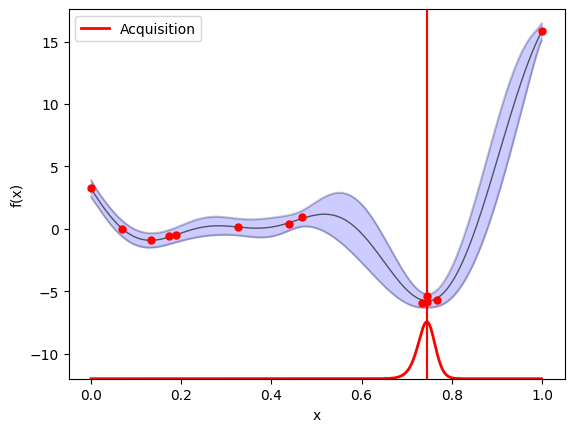

In [16]:
plot_acquisition(myBopt, bounds)

You can only make the previous plot if the dimension of the problem is 1 or 2. However, you can always make a plot to see how the optimization evolved.

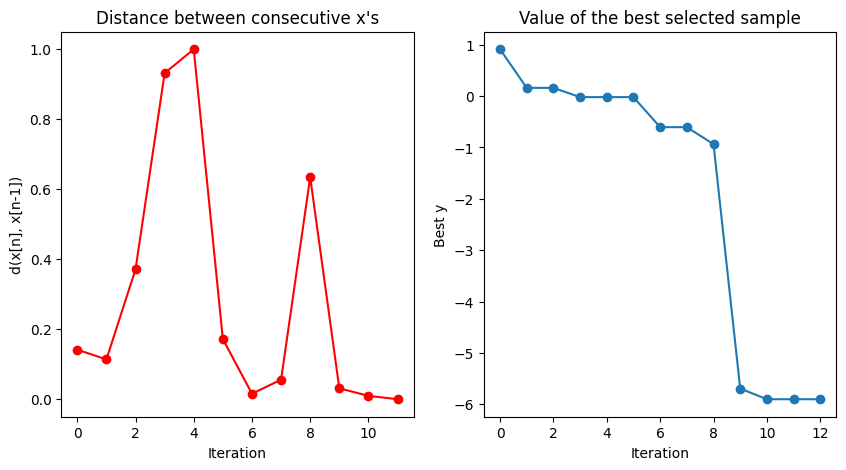

In [17]:
plot_convergence(myBopt.loop_state.X, myBopt.loop_state.Y)

The first plot shows the distance between the last two collected observations at each iteration. This plot is useful to evaluate the convergence of the method. The second plot shows the best found value at each iteration. It is useful to compare different methods. The fastest the curve decreases the better the method. 

### Exercise 1

Use Bayesian optimization to find the minimum of the function $f(x)= x^2 + 10 \sin(x)$ in the interval [-10, 10]. 

(a) Define the bounds of the problem, the function and check that it admits a numpy array of observations as input.

In [31]:
# Define the function
def my_func(x):
    return pow(x,2) + 10 * np.sin(x)

# Define the bounds
my_bounds = ParameterSpace([
    ContinuousParameter('my_var', -10., 10.)
])

# Check that it admits numpy
my_x = np.linspace(0,10,100)


(b) Create an Emukit object for global optimization using a Matern52 kernel. 

In [34]:
my_x_init = np.random.rand(4).reshape(4,1)
my_y_init = my_func(my_x_init)

my_k = GPy.kern.Matern52(1)
my_gp_model = GPy.models.GPRegression(my_x_init, my_y_init, my_k)

# Fix the likelihood variance to be 10e-4
my_gp_model.Gaussian_noise.variance = 10e-4
my_gp_model.Gaussian_noise.fix()

my_emukit_model = GPyModelWrapper(my_gp_model)

(c) For stability reasons, constrain the noise of the model to be 10e-4. 

(d) Run the optimization for 10 iterations. Make and comment the convergence plots. Has the method converged? 

In [39]:
my_b_opt = BayesianOptimizationLoop(space=my_bounds, model=my_emukit_model)
max_iter = 10
my_b_opt.run_loop(user_function=my_func, stopping_condition=max_iter)

 /Users/george/Desktop/Projects/Python/gpss23/.conda/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


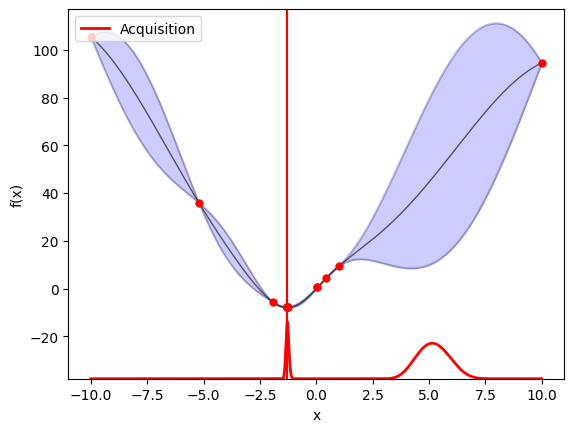

In [40]:
plot_acquisition(my_b_opt, my_bounds)

## 2. Acquisition functions

In this section we are going to have a look to different acquisition functions. Emukit provides a variety of acquisition functions for Bayesian optimization, including the expected improvement ('EI') we already used, the probability of improvement ('PoI') and the lower confidence bound. Emukit uses EI by default, but any other acquisition functions can also be specified. In this section we will create these functions as separate objects and study their behavior.

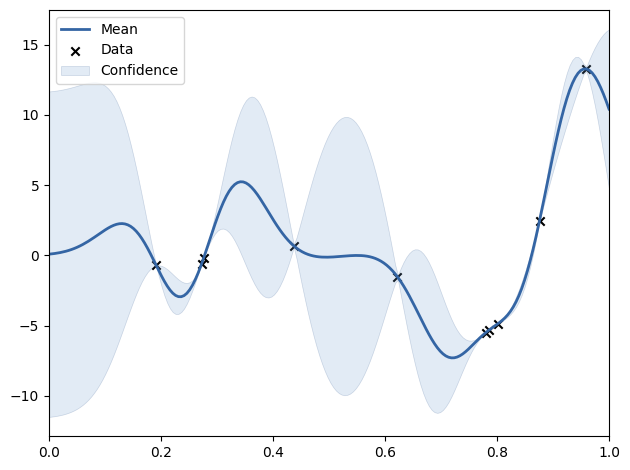

In [41]:
seed(1234)
n = 10
X = np.random.rand(n).reshape(n,1)
Y = f_objective(X)
m = GPy.models.GPRegression(X,Y)
m.optimize()
m.plot([0,1])

## Now we pass this model into a GPyOpt Gaussian process model

from emukit.model_wrappers import GPyModelWrapper
model = GPyModelWrapper(m, n_restarts=5)

We define the bounds of the input space to be between zero and one.

In [42]:
space = ParameterSpace([
    ContinuousParameter('var_1', 0.0, 1.0)
])

Now let's import and create the acquisition function objects.

In [43]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, ProbabilityOfImprovement, NegativeLowerConfidenceBound

In [44]:
acq_EI = ExpectedImprovement(model, jitter=0)
acq_NLCB = NegativeLowerConfidenceBound(model, beta=2.0)
acq_PI = ProbabilityOfImprovement(model, jitter=0)

The objects `acq_EI`, `acq_NLCB`, `acq_PI` contain the acquisition functions and their gradients. By running the following piece of code you can visualize the three acquisitions. In this plot, the larger is the value of the acquisition, the better is the point.

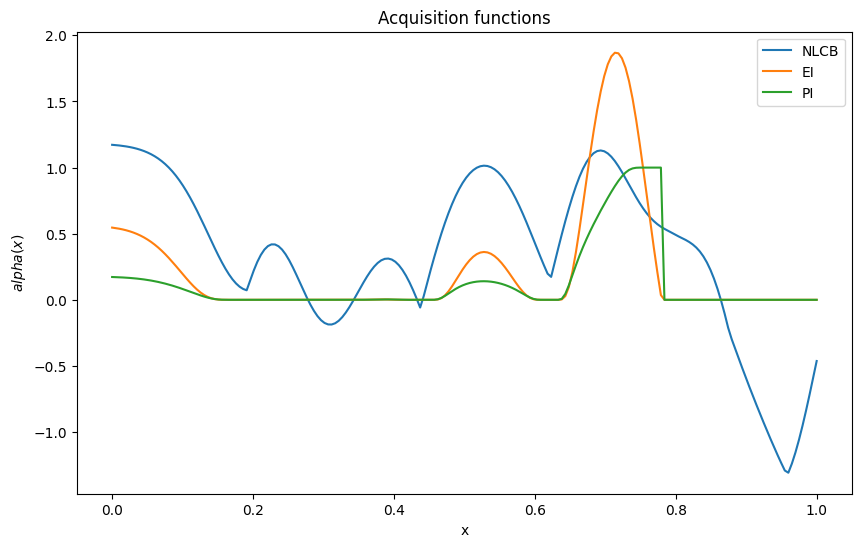

In [45]:
# Plot the three acquisition functions (factor 0.1 added in in the LCB for visualization)
X_grid = np.linspace(0,1,200)[:, None]
plt.figure(figsize=(10,6))
plt.title('Acquisition functions')
plt.plot(X_grid, 0.1*acq_NLCB.evaluate(X_grid), label='NLCB')
plt.plot(X_grid, acq_EI.evaluate(X_grid), label='EI')
plt.plot(X_grid, acq_PI.evaluate(X_grid), label='PI')
plt.xlabel('x')
plt.ylabel('$alpha(x)$')
plt.legend();

### Exercise 2

(a) According to the previous plot, what areas in the domain are worth exploring and why? How can we interpret the previous plot in terms of the exploration/exploitation trade off of each one of the three acquisitions?

> All acquisition functions suggest that the region around 0.7 is worth exploring. 

> NLCB seems the most exploratory as there are many large positive regions. PI seems the most exploitory(?) based on the single large positive position.

(b) Now make a plot comparing the shape of the NLCB acquisition (of GP-UCB in the literature) with values different values of the beta parameter. Use the values $[0,0.1,0.25,0.5,1,2,5]$. How does the decision about where to collect the sample change when we increase the value of the parameter?

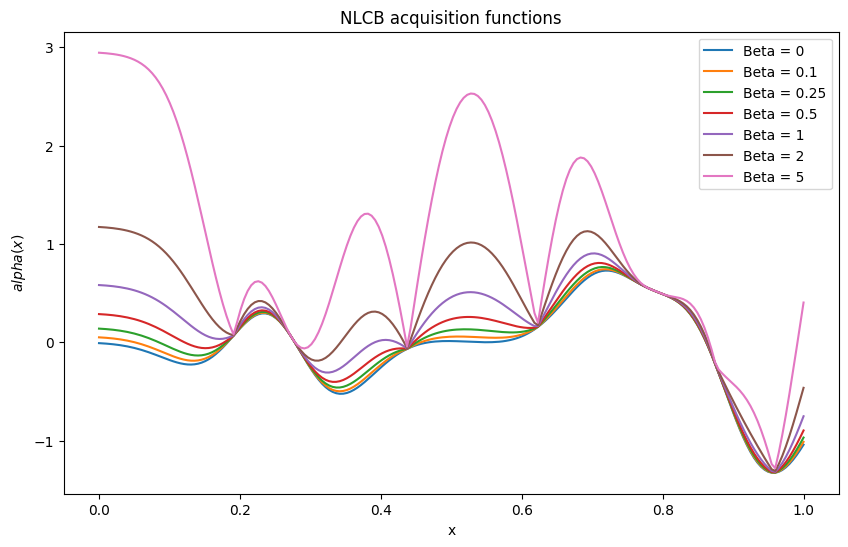

In [48]:
betas = [0, 0.1, 0.25, 0.5, 1, 2, 5]
X_grid = np.linspace(0,1,200)[:, None]

plt.figure(figsize=(10,6))
plt.title('NLCB acquisition functions')

for b in betas:
    acq_NLCB = NegativeLowerConfidenceBound(model, beta=b)
    plt.plot(X_grid, 0.1*acq_NLCB.evaluate(X_grid), label='Beta = ' + str(b))
    
plt.xlabel('x')
plt.ylabel('$alpha(x)$')
plt.legend()

### Exercise 3

Consider the sixhumpcamel function defined as
$$f(x_1,x_2) = \left(4-2.1x_1^2 + \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-2,2]\times [-1,1]$. This function has two global minima, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$. This function is also implemented in Emukit so, to load and visualize it simply run:

In [49]:
from emukit.test_functions import sixhumpcamel_function
f_shc, space_shc = sixhumpcamel_function()

In [50]:
f_shc

<function emukit.test_functions.sixhumpcamel._sixhumpcamel(x)>

(a) Create three objects to optimize this function using EI (with parameter equal to zero), NLCB (with parameter equal to 2) and PI (with parameter equal to zero). Use the same initial data in the three cases.

In [57]:
seed(1234)
n = 10
x_1 = np.random.uniform(-2, 2, n)
x_2 = np.random.uniform(-1, -1, n)
X = np.vstack((x_1.ravel(), x_2.ravel())).T 
Y = f_shc(X)
m = GPy.models.GPRegression(X,Y)
m.optimize()

In [58]:
## Now we pass this model into a GPyOpt Gaussian process model

from emukit.model_wrappers import GPyModelWrapper
model = GPyModelWrapper(m, n_restarts=5)

acq_EI = ExpectedImprovement(model, jitter=0)
acq_NLCB = NegativeLowerConfidenceBound(model, beta=2.0)
acq_PI = ProbabilityOfImprovement(model, jitter=0)



(b) In the three cases run the optimization for 30 iterations

 /Users/george/Desktop/Projects/Python/gpss23/.conda/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /Users/george/Desktop/Projects/Python/gpss23/.conda/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/george/Desktop/Projects/Python/gpss23/.conda/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /var/folders/5w/x9r24t_53yd1wlqr55hh1k880000gn/T/ipykernel_4918/3618114414.py:87: RuntimeWarning:invalid value encountered in divide
 /var/folders/5w/x9r24t_53yd1wlqr55hh1k880000gn/T/ipykernel_4918/3618114414.py:103: RuntimeWarning:invalid value encountered in sqrt
 /Users/george/Desktop/Projects/Python/gpss23/.conda/lib/python3.10/site-packages/matplotlib/contour.py:1494: UserWarning:Warning: converting a masked element to nan.
 /Users/george/Desktop/Projects/Python/gpss23/.conda/lib/python3.10/site-packages/matplotlib/co

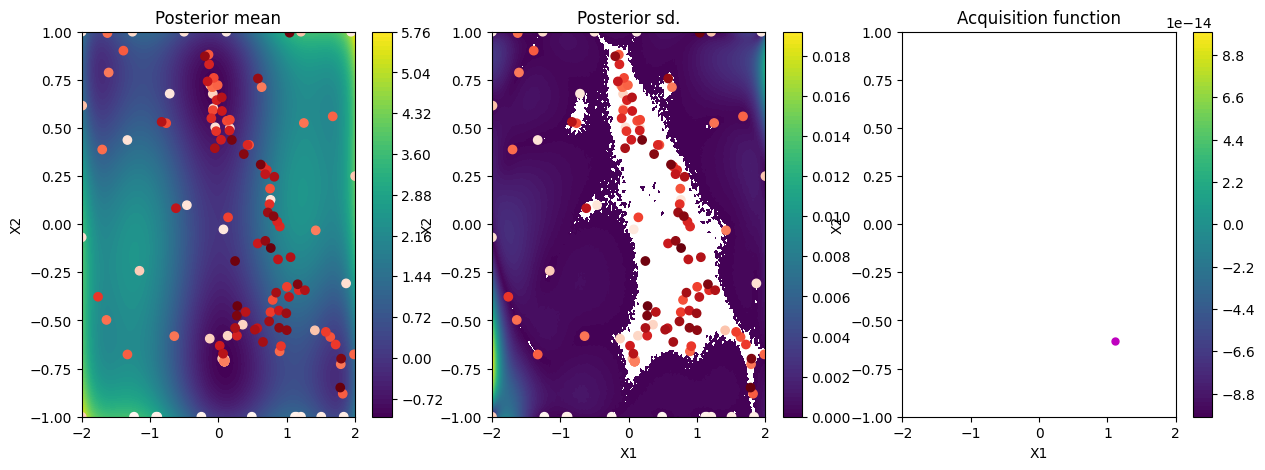

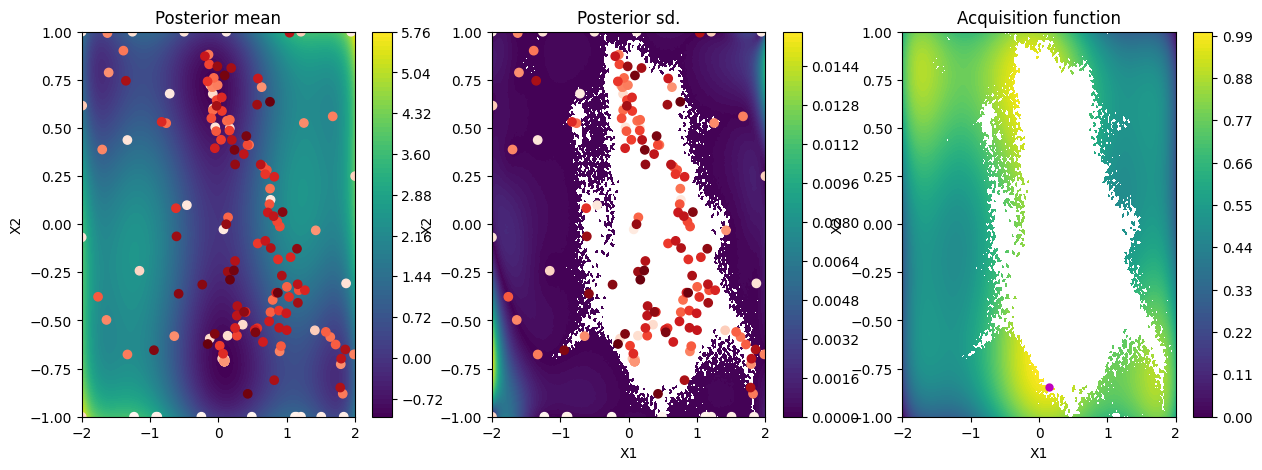

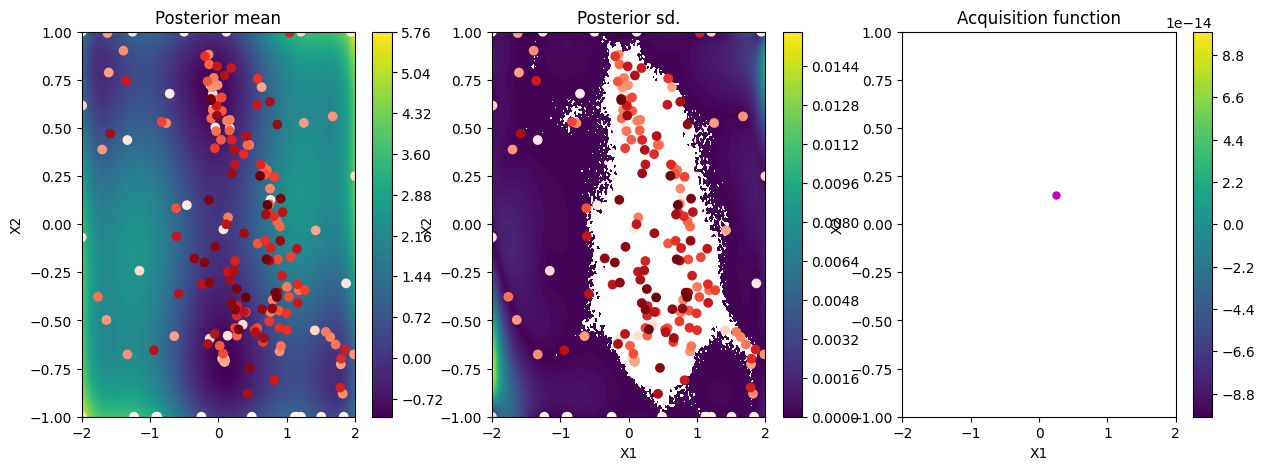

In [61]:
max_iter = 30
acqs = [acq_EI, acq_NLCB, acq_PI]
models = list()

for acq in acqs:
    bo_acq = BayesianOptimizationLoop(
        space=space_shc,
        model=model,
        acquisition=acq
    )
    bo_acq.run_loop(user_function=f_shc, stopping_condition=max_iter)
    models.append(bo_acq)
    plot_acquisition(bo_acq, space_shc)
    

(c) Now make a plot comparing the three methods. The x axis should contain the number of iterations and y axis the best found value. Which acquisition has the best performance in this example?

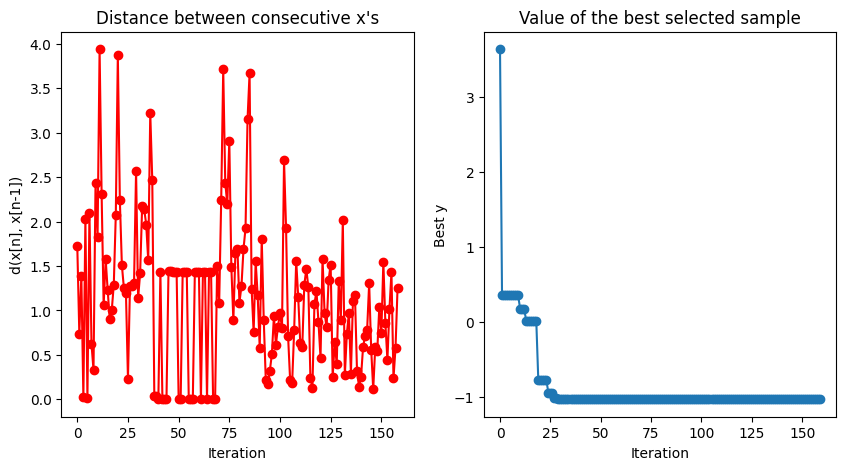

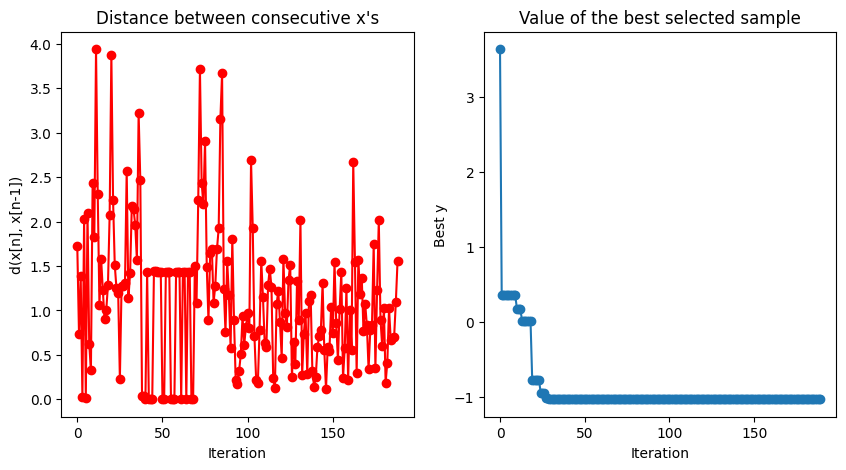

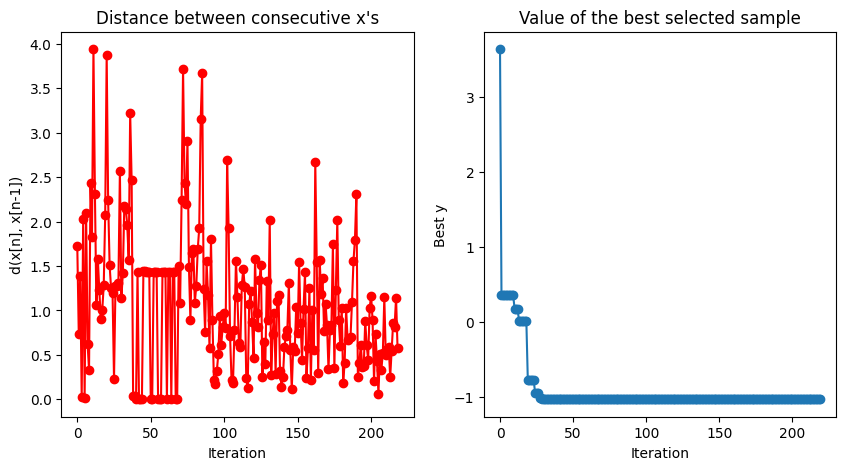

In [63]:
for mo in models:
    plot_convergence(mo.loop_state.X, mo.loop_state.Y)

(d) Compare the models and the acquisition functions in the three cases (after the 30 iterations). What do you observe? 

---
### Credit

This notebook was written by Andrei Paleyes, adopted from the earlier GPyOpt version written by Javier Gonzalez.